<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/Sequence_Learning_on_Cosmetics_Data_4B_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Today you are MLE at the Personalization Department in Macy's cosmetics!
Your goal is to predict outcomes of online browsing sessions through session-level-features or seqeunce of page visits to predict if teh next sequence of events/session outcome will be a purchase or not. Working off session level data is definitely more erroneous than on a journey level, but it provides the opportunity to initiate nudge models/coupons to help personalize at each session level.

Models used in this assignment are similar to https://github.com/guillaume-chevalier/seq2seq-signal-prediction/blob/master/seq2seq.ipynb

## You have two major tasks today:


1.   To process raw session level data to generate sequence data/sequence models.
2.   Compare performance of sequence models with session-feature level models.

## Your manager needs your help to answer the following question: 
Which is the better strategy for session level predictions that lead to presonalization: page visit sequences (less complexity for data pre-process) or session-level features (more data heavy process)?



# Task 0: Getting familiar with the Data!

In [1]:
#Mount the RAW session level data: shopping.pkl
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab/Fourth.Brain/Sequence_Learning/

/content/drive/MyDrive/Colab/Fourth.Brain/Sequence_Learning


In [3]:
%ls

Flask-Tutorial-master.zip                        Sequence_Models.zip
Sequence_Learning_on_Cosmetics_Data_4B_v1.ipynb


In [6]:
!unzip Sequence_Models.zip

Archive:  Sequence_Models.zip
  inflating: Sequence_Models/Session_features.pkl  
  inflating: Sequence_Models/shopping.pkl  


In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/Sequence_Models/')
!ls

Session_features.pkl  shopping.pkl


In [4]:
# Import all libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.layers import Bidirectional
from keras.layers import TimeDistributed

In [88]:
#Read and look at the RAW data
data = pd.read_pickle('Sequence_Models/shopping.pkl')
print('Shape of data=', data.shape)
data.head()

Shape of data= (1500000, 12)


,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,year,month,weekday,hour
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,12,Sunday,0
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,12,Sunday,0
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,12,Sunday,0
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019,12,Sunday,0
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,nan,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019,12,Sunday,0


So for each unique user_session ID, the data fields that are collected are (product ID, category ID, brand, price, user ID, year, month, weekday, hour and the event (view, cart, remove, purchase). Each event is time tagged!

In [89]:
#Next lets look at the feature-level session data
feat = pd.read_pickle('Sequence_Models/Session_features.pkl')
print('Shape of data=', feat.shape)
feat.head()

Shape of data= (1500000, 36)


,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,#ProdsCartedInSession,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,Nov,Oct,Sep,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend,Purchase
0,7,493.0,0,7,1349.46,131.53,0.00,812.941429,0,7,0,7,145.095000,187.166429,0,7,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0
1,18,585.0,1,16,1747.79,152.58,289.52,621.671250,1,16,1,16,461.202273,653.235432,1,16,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
2,1,0.0,0,1,1422.10,1422.10,0.00,1422.100000,0,1,0,1,0.000000,625.779478,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0
3,1,0.0,0,1,308.63,308.63,0.00,308.630000,0,1,0,1,0.000000,609.110000,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
4,11,509.0,4,6,171.90,131.51,171.90,158.220000,4,6,4,6,153.899000,150.426207,4,6,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1


## 1.5M session-level records are given to you. Your goal is to find which data set is best for session-level "purchase" classification!

# Task 1 [Instructor Led]: Generate Data models out of sequence data per session. 
Here, sequence of events (view, cart, remove, purchase) are to be generated per session to see if the sequences just by themselves can indicate if a purchase would occur by the end of the session or not!
This work is the modification from the paper: https://arxiv.org/ftp/arxiv/papers/2010/2010.02503.pdf

## Step 1: Create sequence data per session

In [90]:
# Convert the Events to numeric sequences
events = {'purchase':1,'cart': 2,'view': 3, 'remove_from_cart':4}
data['event'] = data.event_type.map(events)

In [91]:
# Sort the events by 'event time'
data = data.sort_values('event_time')
data.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,year,month,weekday,hour,event
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,12,Sunday,0,4
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,12,Sunday,0,3
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,12,Sunday,0,2
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019,12,Sunday,0,3
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,nan,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019,12,Sunday,0,3


Next, pre-process the data to extract a Purchase (event=1) or not (event>1) label.

In [92]:
sequence = data.groupby('user_session')['event'].apply(list)
sequence = sequence.reset_index()
sequence['purchase'] = sequence['event'].apply(lambda x: 1 if 1 in x else 0)
sequence = sequence[sequence['event'].map(len)> 1]

In [93]:
#The sequence data should not contain the "purchase field" so it is filtered out
sequence['event']= sequence.event.apply(lambda row: list(filter(lambda a: a != 1, row)))
print('Total number of records=', sequence.shape[0])
sequence.head()

Total number of records= 119480


,user_session,event,purchase
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]",0
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]",0
5,0001ebd4-441d-4c2f-a888-929a63b2afe3,"[3, 3, 3, 3, 3, 3, 3, 3]",0
7,00027027-c51e-4b8f-82bc-0122b3d44204,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, ...",0
9,0002b72e-c9b0-4b2e-99c8-a6c8630c4cfe,"[2, 3, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, ...",0


# So 'sequence' represents data regarding per-session browsing sequence.
But what does an average sequence look like? Can some sequences be specifically long and others be too short? Lets analyze...

In [94]:
#Find the length of events per user-session
length = sequence['event'].map(len).to_list()

In [95]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


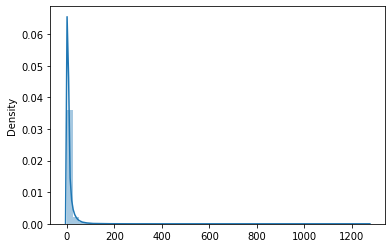

In [96]:
sns.distplot(length)

# So we see, most sequences are about 100 or shorter. 
One major task is to find the optimal sequence size for highet prediction accuracy. Lets try for small and large sequence sizes to find the difference!
# Step 2: Lets analyze upto size 10 sequences and upto size 100 sequences separately!

In [97]:
# select all sequences that are upto 10 events long. Discard remaining sequences.
short_sequence_10 = sequence[sequence['event'].map(len) <= 10]

In [98]:
#Lets see how many records come up
short_sequence_10

,user_session,event,purchase
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]",0
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]",0
5,0001ebd4-441d-4c2f-a888-929a63b2afe3,"[3, 3, 3, 3, 3, 3, 3, 3]",0
10,0002ba44-8b73-4ace-b7c8-fe946aa63cc2,"[3, 2, 2]",0
17,0003d895-8dd0-47c2-94e0-92f7a9031c74,"[3, 3]",0
...,...,...,...
336954,fffb5277-899a-46d8-b51e-2c1f61880f4e,"[3, 2]",0
336963,fffcec5a-c2e3-4e13-8f40-a63f7d14c81f,"[4, 4]",0
336965,fffd3d91-5734-42ac-b149-7403417ec3e2,"[3, 3, 3, 3, 3]",0
336966,fffd5100-6389-486d-8732-9066c47f7ba1,"[3, 3, 2, 3, 3]",0


# Now that you have the limited sequence data, create a data model for it.
# Step 3: Fitting data models: Simple RNN, GRU, LSTM to predict sessions that have a 'purchase' in them.

Apply 70/30 split to data and implement sequence models

In [99]:
event_sequence = short_sequence_10['event'].to_list()

In [100]:
# Pad all sequences with zeros so all inputs have same consistent size of 10
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
event = pad_sequences(event_sequence)

In [101]:
# One Hot Encoding the Purchase label
y = np.array(pd.get_dummies(short_sequence_10['purchase'],prefix='Purchase'))
z=np.sum(y[:,1])/len(y)
print('Percentage of Purchase sessions=',z*100)

Percentage of Purchase sessions= 6.487488415199258


In [102]:
#Define a function to generate 70/30 data split followed by data resizing!
def prepare_train_test_data(data,y):
  #input is data[nxd] and Y[nx2], outputs 70/30 split formatted for the sequence models
  X_train, X_test, y_train, y_test = train_test_split(data, y,                              
                                                    test_size=0.3)
  #Resizing is necessary since input to sequence models is (1,d)
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
  return (X_train,X_test,y_train,y_test)

In [103]:
X_train, X_test, y_train, y_test=prepare_train_test_data(np.array(event),y)
print(X_train.shape, y_train.shape)

(64200, 1, 10) (64200, 2)


## Finally, train and test a sequence model built using: SimpleRNN, GRU and LSTM and compare results!

In [104]:
#Helper functions for this:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score


def plot_history(history):
  # This function will plot the model fit process
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


def evaluate_on_test(X_test, y_test, training_model):
  #This function will evaluate the fit model on test data
  g_preds=training_model.predict_classes(X_test)
  gaccuracy = accuracy_score(y_test[:,1], g_preds)
  print('Accuracy: %f' % gaccuracy)
  # precision tp / (tp + fp)
  gprecision = precision_score(y_test[:,1], g_preds)
  print('Precision: %f' % gprecision)
  # recall: tp / (tp + fn)
  grecall = recall_score(y_test[:,1], g_preds)
  print('Recall: %f' % grecall)
  # f1: 2 tp / (2 tp + fp + fn)
  gf1 = f1_score(y_test[:,1], g_preds)
  print('F1 score: %f' % gf1)


# The following example shows a model designed using Simple RNN. Repeat the same using GRU and LSTM.

In [105]:
from tensorflow.keras.layers import GRU, Embedding, SimpleRNN, Activation
import tensorflow as tf

In [106]:
#This is a simple RNN model
def simple_RNN_model(neurons=40, op=10):
    model = Sequential()
    model.add(SimpleRNN(neurons, return_sequences = True, input_shape = (1,op)))
    model.add(SimpleRNN(2*neurons))
    model.add(Dense(2, activation='softmax'))
    model.compile(
      optimizer=tf.optimizers.Adam(learning_rate=0.0003),
      loss='binary_crossentropy',
      metrics=['acc'])
    return model

In [107]:
#Visualize the Model
tf.keras.backend.clear_session()
RNN_model = simple_RNN_model(neurons=40, op=10)
#RNN_model.summary()

In [108]:
RNN_model

In [109]:
#Fit the model using 80/20 validation split at runtime
r_history = RNN_model.fit(X_train.astype(np.float32), y_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 2s 14ms/step - loss: 0.4664 - acc: 0.9355 - val_loss: 0.2268 - val_acc: 0.9395
Epoch 2/20
52/52 [==============================] - 0s 7ms/step - loss: 0.2246 - acc: 0.9359 - val_loss: 0.1989 - val_acc: 0.9395
Epoch 3/20
52/52 [==============================] - 0s 7ms/step - loss: 0.2067 - acc: 0.9364 - val_loss: 0.1924 - val_acc: 0.9395
Epoch 4/20
52/52 [==============================] - 0s 7ms/step - loss: 0.2002 - acc: 0.9371 - val_loss: 0.1891 - val_acc: 0.9395
Epoch 5/20
52/52 [==============================] - 0s 6ms/step - loss: 0.1989 - acc: 0.9364 - val_loss: 0.1869 - val_acc: 0.9395
Epoch 6/20
52/52 [==============================] - 0s 7ms/step - loss: 0.1994 - acc: 0.9362 - val_loss: 0.1851 - val_acc: 0.9500
Epoch 7/20
52/52 [==============================] - 0s 7ms/step - loss: 0.1951 - acc: 0.9472 - val_loss: 0.1834 - val_acc: 0.9500
Epoch 8/20
52/52 [==============================] - 0s 7ms/step - loss: 0.1968 - acc: 0.9

In [110]:
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 1, 40)             2040      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 80)                9680      
_________________________________________________________________
dense (Dense)                (None, 2)                 162       
Total params: 11,882
Trainable params: 11,882
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


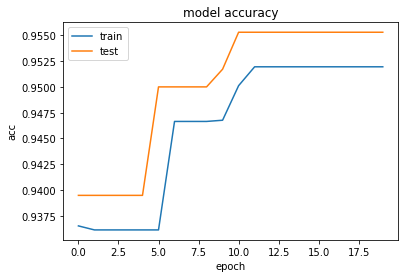

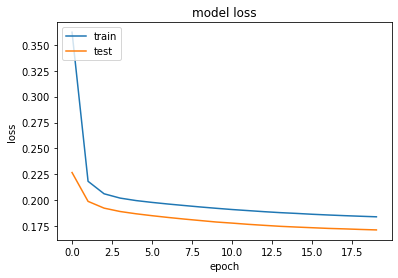

In [111]:
plot_history(r_history)

In [112]:
evaluate_on_test(X_test,y_test,RNN_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.947556
Precision: 1.000000
Recall: 0.237718
F1 score: 0.384123


# Task 2: Run GRU and LSTM Models on the 10-sequence data. 
Which is the best model? What is the metric of most importance?


In [113]:
###############START CODE HERE##########################################################################
#Define a GRU model function. Use the simple_RNN_model function and replace the RNN layers with GRU.
#Notice the change in number of parameters
def GRU_model(neurons=40, op=10):
  model = Sequential()
  model.add(GRU(neurons, return_sequences = True, input_shape = (1,op)))
  model.add(GRU(2*neurons))
  model.add(Dense(2, activation='softmax'))
  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['acc'])
  return model

In [114]:
#Visualize the Model (Notice the increase in parameters)
tf.keras.backend.clear_session()
G_model = GRU_model()#neurons=40, op=10)
G_model.build(input_shape=(None, 1, 10))
G_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 1, 40)             6240      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 80)                29280     
_________________________________________________________________
dense (Dense)                (None, 2)                 162       
Total params: 35,682
Trainable params: 35,682
Non-trainable params: 0
_________________________________________________________________


In [115]:
#Train the G_model (20 epochs, 1000 samples per batch, validation split=0.2)
g_history = G_model.fit(X_train.astype(np.float32), y_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 4s 26ms/step - loss: 0.5886 - acc: 0.9356 - val_loss: 0.3853 - val_acc: 0.9395
Epoch 2/20
52/52 [==============================] - 0s 6ms/step - loss: 0.3390 - acc: 0.9363 - val_loss: 0.2384 - val_acc: 0.9395
Epoch 3/20
52/52 [==============================] - 0s 6ms/step - loss: 0.2394 - acc: 0.9352 - val_loss: 0.2099 - val_acc: 0.9395
Epoch 4/20
52/52 [==============================] - 0s 6ms/step - loss: 0.2195 - acc: 0.9352 - val_loss: 0.1993 - val_acc: 0.9395
Epoch 5/20
52/52 [==============================] - 0s 6ms/step - loss: 0.2146 - acc: 0.9339 - val_loss: 0.1952 - val_acc: 0.9395
Epoch 6/20
52/52 [==============================] - 0s 6ms/step - loss: 0.2033 - acc: 0.9367 - val_loss: 0.1929 - val_acc: 0.9395
Epoch 7/20
52/52 [==============================] - 0s 6ms/step - loss: 0.2034 - acc: 0.9366 - val_loss: 0.1913 - val_acc: 0.9395
Epoch 8/20
52/52 [==============================] - 0s 6ms/step - loss: 0.2032 - acc: 0.9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


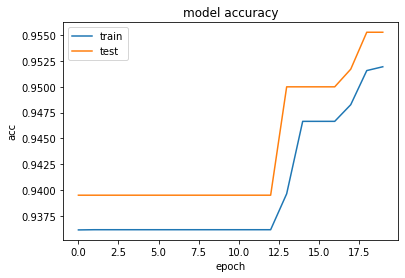

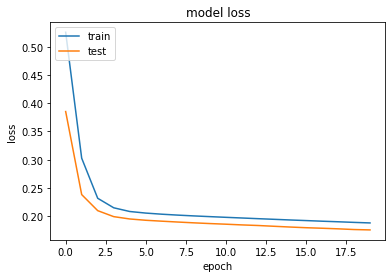

In [116]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(g_history)

In [117]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test.astype(np.float32),y_test,G_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.947556
Precision: 1.000000
Recall: 0.237718
F1 score: 0.384123


In [67]:
#Define an LSTM model function. Use the LSTM layer as shown below.
#Notice the change in number of parameters
def LSTM_model(neurons=40, op=1):
  #first define Sequential model
  model = Sequential()
  model.add(Bidirectional(LSTM(neurons, return_sequences=True), input_shape=(1,op)))
  #Add more layers
  model.add(LSTM(2*neurons))
  model.add(Dense(2, activation='softmax'))
  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['acc'])
  return model

In [68]:
tf.keras.backend.clear_session()
training_model = LSTM_model(neurons=40, op=10)
training_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 80)             16320     
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense (Dense)                (None, 2)                 162       
Total params: 68,002
Trainable params: 68,002
Non-trainable params: 0
_________________________________________________________________


In [69]:
#Train the training_model (20 epochs, 1000 samples per batch, validation split=0.2)
lstm_history = training_model.fit(X_train.astype(np.float32), y_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 11s 33ms/step - loss: 0.6600 - acc: 0.8746 - val_loss: 0.5291 - val_acc: 0.9356
Epoch 2/20
52/52 [==============================] - 0s 8ms/step - loss: 0.4646 - acc: 0.9351 - val_loss: 0.2823 - val_acc: 0.9356
Epoch 3/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2591 - acc: 0.9358 - val_loss: 0.2196 - val_acc: 0.9356
Epoch 4/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2183 - acc: 0.9344 - val_loss: 0.2056 - val_acc: 0.9356
Epoch 5/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2106 - acc: 0.9341 - val_loss: 0.2019 - val_acc: 0.9356
Epoch 6/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2031 - acc: 0.9357 - val_loss: 0.2001 - val_acc: 0.9356
Epoch 7/20
52/52 [==============================] - 0s 9ms/step - loss: 0.2072 - acc: 0.9338 - val_loss: 0.1988 - val_acc: 0.9356
Epoch 8/20
52/52 [==============================] - 0s 8ms/step - loss: 0.1986 - acc: 0.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


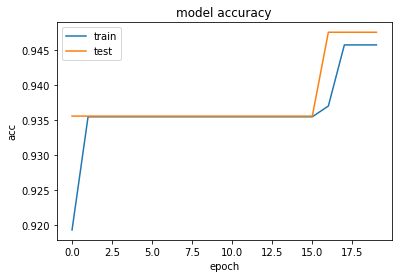

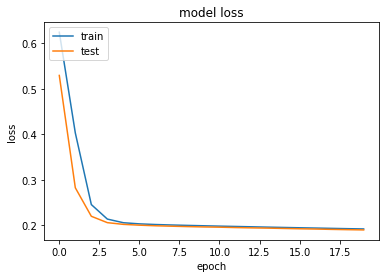

In [70]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(lstm_history)

In [71]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test.astype(np.float32),y_test,training_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.944648
Precision: 1.000000
Recall: 0.158564
F1 score: 0.273724


# Task 3: Create sequence data upto size 300. Apply 70/30 split for train-test data.
# Next, fit ONLY the best data model (pick ONE between simple RNN /GRU/ LSTM reported in Task 2) on this data.


In [118]:
#Step 1: Create sequence upto 300
short_sequence_300 = sequence[sequence['event'].map(len) <= 300]
event_sequence_300 = short_sequence_300['event'].to_list()
event_300 = pad_sequences(event_sequence_300)

In [119]:
# One Hot Encoding the Purchase label
y_300 = np.array(pd.get_dummies(short_sequence_300['purchase'],prefix='Purchase'))
# Function call to 'prepare_train_test_data' to create 70/30 split data
X_train_300, X_test_300, y_train_300, y_test_300= X_train, X_test, y_train, y_test=prepare_train_test_data(np.array(event_300),y_300)
print(X_train_300.shape, y_train_300.shape)

(83594, 1, 300) (83594, 2)


In [120]:
# Initialize your best model (RNN or GRU or LSTM)
tf.keras.backend.clear_session()
RNN_model = simple_RNN_model(neurons=40, op=10)

In [121]:
#Fit your model on Training data (20 epochs, 1000 samples per batch, validation_split=0.2)
r_history = RNN_model.fit(X_train.astype(np.float32), y_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
67/67 [==============================] - 3s 13ms/step - loss: 0.5489 - acc: 0.8217 - val_loss: 0.3164 - val_acc: 0.9072
Epoch 2/20
67/67 [==============================] - 1s 8ms/step - loss: 0.3098 - acc: 0.9035 - val_loss: 0.2775 - val_acc: 0.9072
Epoch 3/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2825 - acc: 0.9051 - val_loss: 0.2710 - val_acc: 0.9071
Epoch 4/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2718 - acc: 0.9075 - val_loss: 0.2686 - val_acc: 0.9072
Epoch 5/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2750 - acc: 0.9048 - val_loss: 0.2674 - val_acc: 0.9072
Epoch 6/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2731 - acc: 0.9054 - val_loss: 0.2661 - val_acc: 0.9073
Epoch 7/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2696 - acc: 0.9066 - val_loss: 0.2652 - val_acc: 0.9071
Epoch 8/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2749 - acc: 0.9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


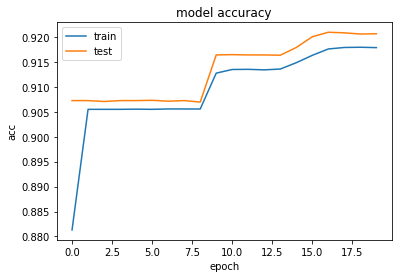

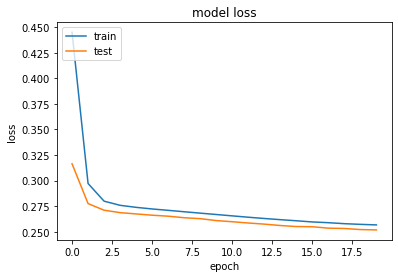

In [122]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(r_history)

In [123]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test.astype(np.float32),y_test,RNN_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.918383
Precision: 0.972093
Recall: 0.125526
F1 score: 0.222340


# Task 4: Finally apply feature-based classification on the session-feature level data (Session_features.pkl).

Apply your best model so far on 70/30 split data for session-feature level data and report your outcome!

In [124]:
#data=feat, conrains X and Y(last column)
Xf=feat.iloc[:,0:34]
Yf=feat.iloc[:,35]
#########################START CODE HERE##########################
Xf_train, Xf_test, yf_train, yf_test= prepare_train_test_data(np.array(Xf),np.array(Yf)) # Function call to 'prepare_train_test_data' to create 70/30 split data
print(Xf_train.shape, yf_train.shape)

(1050000, 1, 34) (1050000,)


In [125]:
#Initialize ANY model (RNN or GRU or LSTM)
tf.keras.backend.clear_session()
RNN_model = simple_RNN_model(neurons=40, op=10)

In [126]:
#Fit your model on Training data (20 epochs, 1000 samples per batch, validation_split=0.2)
r_history = RNN_model.fit(X_train.astype(np.float32), y_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
67/67 [==============================] - 3s 13ms/step - loss: 0.5143 - acc: 0.8302 - val_loss: 0.3065 - val_acc: 0.9072
Epoch 2/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2994 - acc: 0.9059 - val_loss: 0.2744 - val_acc: 0.9072
Epoch 3/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2799 - acc: 0.9043 - val_loss: 0.2692 - val_acc: 0.9072
Epoch 4/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2696 - acc: 0.9083 - val_loss: 0.2672 - val_acc: 0.9072
Epoch 5/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2757 - acc: 0.9038 - val_loss: 0.2661 - val_acc: 0.9072
Epoch 6/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2710 - acc: 0.9057 - val_loss: 0.2650 - val_acc: 0.9072
Epoch 7/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2673 - acc: 0.9067 - val_loss: 0.2636 - val_acc: 0.9072
Epoch 8/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2696 - acc: 0.9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


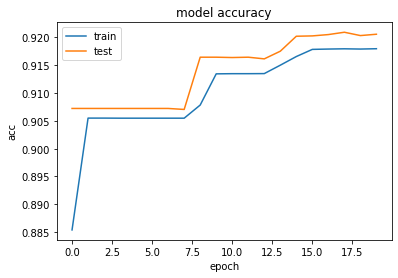

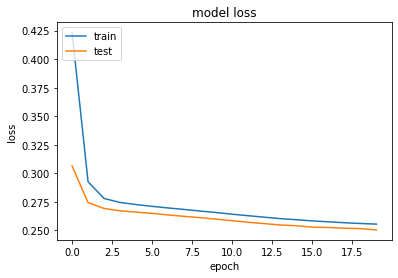

In [127]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(r_history)

In [128]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test.astype(np.float32),y_test,RNN_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.918439
Precision: 0.978873
Recall: 0.125225
F1 score: 0.222045


# **Summary and Discussion:** **Discuss** "What would you report back to your manager?" 
# Think in terms of Data, Process and Outcomes specifically.
## Consider the following:
1. Is feature-level data necessary? What metrics suggest that?
2. Is sequence-level data sufficient? What sequence size would you suggest?
3. What is the metric/metrics you would use to report your results?

#Share screen and discuss findings. Think about generalizability (something that works across data sets)
